# Embeddings de palavras
## Um classificador de sentimentos baseado nas críticas de filmes do IMDB

Modelos de _machine learning_ recebem dados numéricos como entrada. Portanto, para realizar o processamento de palavras é necessário aplicar algum método de conversão. 
Existem algumas abordagens, conforme segue:
1. **One hot**: Se trata de representar cada palavra de um dado conjunto como um valor numérico distinto, utilizando-se apenas de valores binários (0 e 1):

<img src='https://miro.medium.com/max/700/1*O_pTwOZZLYZabRjw3Ga21A.png'/>
Figura 1 - Vetor de One-hot encoding. Fonte: [towardsdatascience.com] (https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809)

2. **Atribuir a cada palavra um valor inteiro aleatório**. Ex:
  |Gato | Bola | Rato | Queijo|
  | ---- | ----- | ----- | ----- |
  |5 | 8 | 3 | 1|

3. **_Embedding_ de palavras**: Consiste em atribuir um vetor de tamanho fixo para representar as palavras. O tamanho do vetor pode ser escolhido manualmente (geralmente levando-se em consideração o tamanho do conjunto de dados), no entanto os valores são atribuídos automaticamente como pesos aprendidos pelos modelos. Com isso, a representação da palavra passa a ter um significado, onde palavras mais fortemente relacionados estarão mais próximas entre si. 

## Comparação entre os métodos apresentados
Representar as palavras utilizando a técnica de one-hot encoding pode ser ineficiente, pois teríamos, principalmente em basses de dados grandes, muitas dimensões e com números (zeros) repetidos em 99,9% das vezes, o que se torna em um vetor escasso. A segunda abordagem citada pode parecer mais aplicável, pois cada palavra será representada por um número distinto. O viés desta técnica é que não haverá nenhuma relação entre as palavras, ligada ao seu significado. A terceira forma apresentada atribui valores que estão relacionados de alguma forma ao o quecada palavra significa.

Na sequência, será aplicada a técnica de embedding de palavras a uma base de dados de críticas de filmes do [IMDB](https://www.imdb.com/).

## Configuração

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Camada de embeddings

Na sessão anterior foi explicado que, nesta abordagem, cada palavra é representada por um vetor denso. 
A camada de embeddings nada mais é do que uma matriz que relaciona cada índice de uma palavra (número inteiro) a um vetor denso, ou _embedding_.
Na inicialização abaixo, temos um vocabulário de 1000 palavras e um vetor de 5 dimensões (tamanho fixo) para representa cada palavra. Os valores de ponto flutuante (pesos) nos embeddings são atribuídos aleatoriamente e serão ajustados por _backpropagation_ aproximando as palavras por semelhança.

In [2]:
embedding_layer = layers.Embedding(1000, 5)

Ao passar um vetor de inteiros para a função `embedding_layer()`, esta retorna os vetores densos respectivos ao índices passados:

In [3]:
result = embedding_layer(tf.constant([1,2,3]))
print("======= 3 embeddings pertencentes aos índices [1, 2, 3] respectivamente: =======")
print()
print(result.numpy())
print()
print("======= embeddings pertencentes aos índices [[1, 2, 3] [4, 5, 6]], respectivamente: =======")
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result

======= 3 embeddings pertencentes aos índices [1, 2, 3] respectivamente: =======

[[-0.02675997  0.02044157 -0.01202003  0.03798063  0.03595218]
 [ 0.04804147  0.00705868  0.02513948  0.02426311 -0.00118761]
 [ 0.0395375   0.03951658 -0.01552973 -0.01714464 -0.04022117]]

======= embeddings pertencentes aos índices [[1, 2, 3] [4, 5, 6]], respectivamente: =======


<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[-0.04888009,  0.02668187,  0.01199325, -0.007107  ,
          0.04688461],
        [-0.02675997,  0.02044157, -0.01202003,  0.03798063,
          0.03595218],
        [ 0.04804147,  0.00705868,  0.02513948,  0.02426311,
         -0.00118761]],

       [[ 0.0395375 ,  0.03951658, -0.01552973, -0.01714464,
         -0.04022117],
        [ 0.0035943 ,  0.00318234, -0.01507302,  0.02970947,
          0.04309196],
        [ 0.02700115, -0.02096868,  0.03736966, -0.02265607,
         -0.02417264]]], dtype=float32)>

\
\
Agora vamos carregar os dados de avaliações de filmes do IMDB em dados de treinamento e teste. Vamos também verificar algumas informações adicionais sobre o _dataset_.

In [5]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

In [21]:
print("======= Descrição dos dados =======")
print()
print(info.description)
print()
print("Tamanho: ", info.dataset_size)
print()
print("Atributos: ", info.features.keys())

======= Descrição dos dados =======

Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

Tamanho:  54.72 MiB

Atributos:  dict_keys(['text', 'label'])


In [11]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [12]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [13]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6058 - accuracy: 0.6607 - val_loss: 0.3617 - val_accuracy: 0.8600
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2967 - accuracy: 0.8890 - val_loss: 0.3945 - val_accuracy: 0.8600
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2348 - accuracy: 0.9143 - val_loss: 0.4263 - val_accuracy: 0.8400
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2016 - accuracy: 0.9274 - val_loss: 0.4250 - val_accuracy: 0.8700
Epoch 5/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1733 - accuracy: 0.9393 - val_loss: 0.4693 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1567 - accuracy: 0.9449 - val_loss: 0.3686 - val_accuracy: 0.8750
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1435 - accuracy: 0.9475 - val_loss: 0.2813 - val_accuracy:

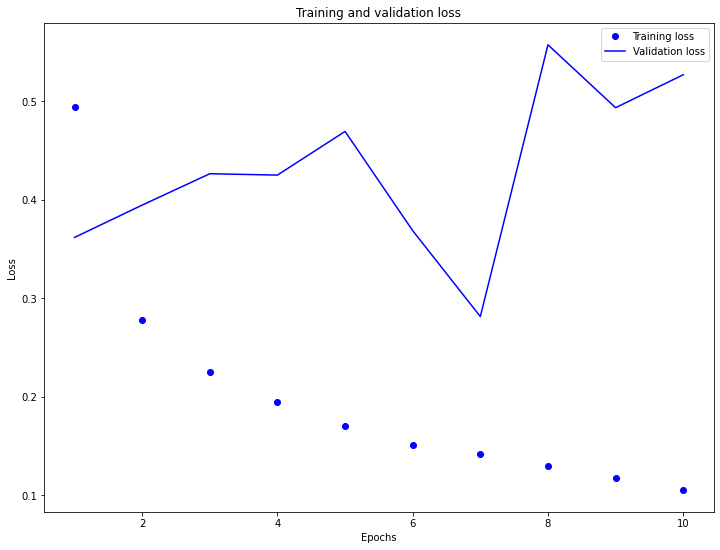

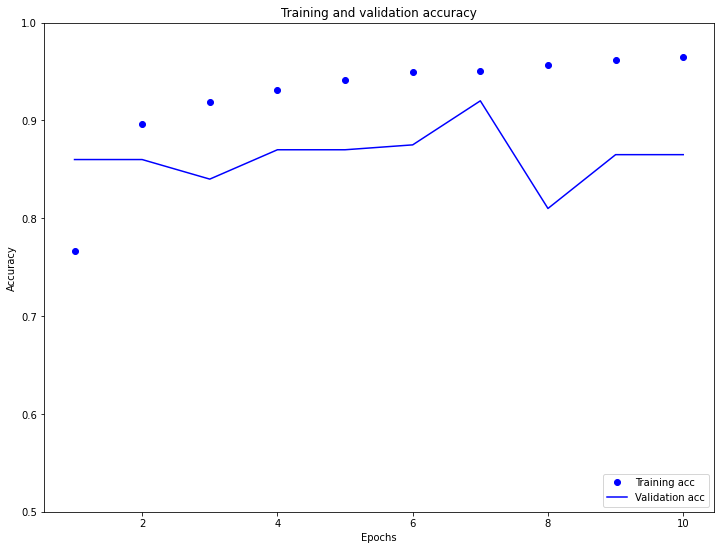

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # formato: (vocab_size, embedding_dim)

(8185, 16)


In [17]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # pule o 0, está preenchido.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [18]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')